In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# this dataset will crash the kernel if loaded fully, so we need to load a sampled version of it
# data = pd.read_csv('../../data/NF-UNSW-NB15-v3/data/NF-UNSW-NB15-v3.csv')
# # drop data with NaN or inf values
# data.replace([np.inf, -np.inf], np.nan, inplace=True)
# data = data.dropna()
# data.reset_index(drop=True, inplace=True)

In [3]:
from data_cleaning import clean_nfunsw_nb15

# load this dataset and clean it
data = pd.read_csv('../../data/NF-UNSW-NB15-v3/data/NF-UNSW-NB15-v3.csv')

data = clean_nfunsw_nb15(data)

[clean] Step 1/3: dropped rows missing IP/ports: 0 (from 2365424 -> 2365424)
[clean] Step 2/3: columns with ±inf and/or missing values detected:
        ['DST_TO_SRC_SECOND_BYTES', 'SRC_TO_DST_SECOND_BYTES']
[clean] Step 3/3: filled 244986 missing numeric values with 0.
[clean] Done. Final shape: (2365424, 55)


In [4]:
""" # Sample 10% of the data, stratified by 'label' to validate the algorithm. keep category distribution
sampled_data, _ = train_test_split(
    data,
    test_size=0.9,  # Keep 10%
    stratify=data['Attack'],
    random_state=42
)

# Use sampled_data for the rest of the notebook
data = sampled_data """

" # Sample 10% of the data, stratified by 'label' to validate the algorithm. keep category distribution\nsampled_data, _ = train_test_split(\n    data,\n    test_size=0.9,  # Keep 10%\n    stratify=data['Attack'],\n    random_state=42\n)\n\n# Use sampled_data for the rest of the notebook\ndata = sampled_data "

In [5]:
data.head()

,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,...,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Label,Attack
0,1424242193040,1424242193043,59.166.0.2,4894,149.171.126.3,53,17,5.0,146,2,...,0,0,0,0,0,0,0,0,0,Benign
1,1424242192744,1424242193079,59.166.0.4,52671,149.171.126.6,31992,6,11.0,4704,28,...,0,91,12,19,0,90,12,19,0,Benign
2,1424242190649,1424242193109,59.166.0.0,47290,149.171.126.9,6881,6,37.0,13662,238,...,0,1843,10,119,0,1843,5,88,0,Benign
3,1424242193145,1424242193146,59.166.0.8,43310,149.171.126.7,53,17,5.0,146,2,...,0,0,0,0,0,0,0,0,0,Benign
4,1424242193239,1424242193241,59.166.0.1,45870,149.171.126.1,53,17,5.0,130,2,...,0,0,0,0,0,0,0,0,0,Benign


In [6]:
# anonymize IP addresses by replacing them with random private IPs in the range
#data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [7]:
# convert IP addresses and ports to string type then concatenate them to form unique node identifiers
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2365424 entries, 0 to 2365423
Data columns (total 53 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   FLOW_START_MILLISECONDS      int64  
 1   FLOW_END_MILLISECONDS        int64  
 2   IPV4_SRC_ADDR                object 
 3   IPV4_DST_ADDR                object 
 4   PROTOCOL                     int64  
 5   L7_PROTO                     float64
 6   IN_BYTES                     int64  
 7   IN_PKTS                      int64  
 8   OUT_BYTES                    int64  
 9   OUT_PKTS                     int64  
 10  TCP_FLAGS                    int64  
 11  CLIENT_TCP_FLAGS             int64  
 12  SERVER_TCP_FLAGS             int64  
 13  FLOW_DURATION_MILLISECONDS   int64  
 14  DURATION_IN                  int64  
 15  DURATION_OUT                 int64  
 16  MIN_TTL                      int64  
 17  MAX_TTL                      int64  
 18  LONGEST_FLOW_PKT             int64  
 19  SHORT

,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Label,Attack
0,1424242193040,1424242193043,59.166.0.2:4894,149.171.126.3:53,17,5.0,146,2,178,2,...,0,0,0,0,0,0,0,0,0,Benign
1,1424242192744,1424242193079,59.166.0.4:52671,149.171.126.6:31992,6,11.0,4704,28,2976,28,...,0,91,12,19,0,90,12,19,0,Benign
2,1424242190649,1424242193109,59.166.0.0:47290,149.171.126.9:6881,6,37.0,13662,238,548216,438,...,0,1843,10,119,0,1843,5,88,0,Benign
3,1424242193145,1424242193146,59.166.0.8:43310,149.171.126.7:53,17,5.0,146,2,178,2,...,0,0,0,0,0,0,0,0,0,Benign
4,1424242193239,1424242193241,59.166.0.1:45870,149.171.126.1:53,17,5.0,130,2,162,2,...,0,0,0,0,0,0,0,0,0,Benign


In [8]:
# we don't need the Label column as we are doing multiclass classification
data.drop(columns=['Label'],inplace = True)

In [9]:
data.rename(columns={"Attack": "label"},inplace = True)

## Chronological split of data to 60/30/10

In [10]:
from chronological_split import (
    make_chronological_split_indices,
    save_split_indices, load_split_indices,
    save_split_frames,
)

# df_clean = ...  # output of your data_cleaning.clean_nfunsw_nb15(df_raw)

# 1) Create indices (once)
train_idx, val_idx, test_idx, meta = make_chronological_split_indices(
    data,
    start_col="FLOW_START_MILLISECONDS",  # in ms
    end_col="FLOW_END_MILLISECONDS",
    dur_col="FLOW_DURATION_MILLISECONDS",
    train_ratio=0.60, val_ratio=0.30, test_ratio=0.10, #change to other ratios if needed
)

# 2) Persist indices for future runs
save_split_indices("artifacts/splits", train_idx, val_idx, test_idx, meta)

# (Optional) also dump the materialized split datasets now for reuse
save_split_frames(data, train_idx, val_idx, test_idx, out_dir="artifacts/splits", fmt="parquet")

# 3) In any future run (graph build, feature store, training), load the SAME indices:
train_idx2, val_idx2, test_idx2, meta2 = load_split_indices("artifacts/splits")

# Use them to subset clean dataframe (data) deterministically
df_train = data.loc[train_idx2]
df_val   = data.loc[val_idx2]
df_test  = data.loc[test_idx2]

[split] Chronological 60/30/10 with boundary safety
        TRAIN:  1419254  t∈[1421927376907, 1424229622767]
        VAL:     709628  t∈(1424229622767, 1424254516414]
        TEST:    236542  t∈(1424254516414, 1424262564927]
[split] Saved indices → artifacts/splits/split_indices.npz and meta → artifacts/splits/meta.json
[split] Saved materialized splits to artifacts/splits (parquet).


## Label encoding

In [11]:
from label_mapping import fit_label_map, transform_labels, save_label_map, load_label_map, class_weights_from_train

# 1) Fit mapping on TRAIN ONLY
label2id = fit_label_map(df_train["label"], order="alpha")  # or order="freq"
save_label_map("artifacts/label_map.json", label2id)

# 2) Apply mapping to all splits (consistent)
label2id = load_label_map("artifacts/label_map.json")
y_train = transform_labels(df_train["label"], label2id)  # np.int64
y_val   = transform_labels(df_val["label"], label2id)
y_test  = transform_labels(df_test["label"], label2id)

# (Optional) sanity check: ensure no -1 slipped in
assert (y_train >= 0).all(), "Train split has unseen/missing labels."

# 3) Class weights for loss
weights = class_weights_from_train(y_train, num_classes=len(label2id))

## Numerical transformation
### Remove highly corelated features
This function visualise correlation between given features.
Also performs log1p, scaler, zero-variance drop, optional Spearman prune on numericals
Applies transformation to test and validation

In [12]:
from corr_visualisation import plot_numeric_corr_heatmap
from feature_numeric import fit_numeric_transform, transform_numeric

# 0) Columns to EXCLUDE here because they’re numeric-coded categoricals:
numeric_cats = [
    "PROTOCOL", "L7_PROTO",
    "ICMP_TYPE", "ICMP_IPV4_TYPE",
    "DNS_QUERY_TYPE", "DNS_QUERY_ID",
    "FTP_COMMAND_RET_CODE",
    # any other *_TYPE / *_ID style columns you want one-hot later
]

# 1) Correlation heatmap (pre-pruning) on TRAIN only
viz_info = plot_numeric_corr_heatmap(
    df_train,
    exclude_numeric_categoricals=numeric_cats,
    out_dir="artifacts/corr",
    threshold=0.995,         # same ballpark as your pruning threshold
    max_features=150,        # avoid unreadable giant plots
    nonneg_frac=0.995,       # infer nonnegative cols for log1p
    topk_pairs=100,
    filename_prefix="spearman_corr_train"
)
print("[corr-viz]", viz_info)

# 2) TRAIN: fit numeric pipeline (log1p, scaler, zero-variance drop, optional Spearman prune)
Xnum_train, num_arts = fit_numeric_transform(
    df_train,
    exclude_numeric_categoricals=numeric_cats,
    scaler_type="standard",           # or "robust" if outliers are extreme
    apply_corr_prune=True,
    corr_threshold=0.995,
    artifacts_dir="artifacts/numeric"
)
print("[numeric] train shape:", Xnum_train.shape)

# 2) VAL/TEST: apply frozen transforms
Xnum_val, _  = transform_numeric(df_val,  artifacts_dir="artifacts/numeric")
Xnum_test, _ = transform_numeric(df_test, artifacts_dir="artifacts/numeric")
print("[numeric] val/test shapes:", Xnum_val.shape, Xnum_test.shape)

[corr-viz] {'n_numeric': 42, 'n_plotted': 42, 'threshold': 0.995, 'nonneg_frac': 0.995, 'png_path': 'artifacts/corr\\spearman_corr_train_full.png', 'pairs_csv': 'artifacts/corr\\spearman_corr_train_top_pairs.csv'}
[numeric] train shape: (1419254, 38)
[numeric] val/test shapes: (709628, 38) (236542, 38)


## Categorical encoding
fits a OneHotEncoder on TRAIN only (sparse CSR, float32),
handles numeric-coded categoricals (e.g., PROTOCOL, L7_PROTO, *_TYPE, *_ID),
Optionally puts IPv4 ports in buckets, collapses rare categories (by min_freq or top_k) - not used here as we droped IPv4 ports after encoding it to unique hosts with IP addresses

persists artifacts (encoder + per-column metadata) for deterministic transforms,
transforms VAL/TEST,
returns CSR matrices ready to stack with numeric transformation.

In [13]:
from categorical_encoding import fit_categorical_transform, transform_categorical

# Choose categorical columns (include your numeric-coded categoricals here!)
cat_cols = [
    "PROTOCOL", "L7_PROTO",
    "ICMP_TYPE", "ICMP_IPV4_TYPE",
    "DNS_QUERY_TYPE", "DNS_QUERY_ID",
    "FTP_COMMAND_RET_CODE",
    # If you want ports as categories (after port bucketing):
    # "L4_SRC_PORT", "L4_DST_PORT", # we dropped ports after concatenating them to IP addresses
    # any other *_TYPE / *_ID style columns you want one-hot
]

# 1) TRAIN — fit encoder (optionally collapse rare cats)
Xcat_train, cat_arts = fit_categorical_transform(
    df_train,
    cat_cols=cat_cols,
    use_port_buckets=False,     # buckets ports into IANA groups to avoid huge dims
    min_freq=50,               # collapse categories with <50 occurrences to "__RARE__" (tune as needed)
    top_k=None,                # or e.g., top_k=20 to keep top-20 per column
    artifacts_dir="artifacts/categorical",
)
print("[categorical] train CSR shape:", Xcat_train.shape)

# 2) VAL/TEST — apply frozen encoder
Xcat_val  = transform_categorical(df_val,  artifacts_dir="artifacts/categorical")
Xcat_test = transform_categorical(df_test, artifacts_dir="artifacts/categorical")
print("[categorical] val/test CSR shapes:", Xcat_val.shape, Xcat_test.shape)


[categorical] train CSR shape: (1419254, 563)
[categorical] val/test CSR shapes: (709628, 563) (236542, 563)


## Prepare feature store for mini-batch and other
What: Persist transformed features by split, not in the graph.
Why: Memory safety; fast random access by batch.

a) mini-batch with neighbrour sampling (k-layers)
b) random walk

In [14]:
from feature_store import build_feature_store

# We already have:
# df_train, df_val, df_test       (chronological splits)
# y_train, y_val, y_test          (int labels via label_mapping)
# train_idx, val_idx, test_idx    (global edge indices from persist_splits)

numeric_cats = [
    "PROTOCOL","L7_PROTO","ICMP_TYPE","ICMP_IPV4_TYPE",
    "DNS_QUERY_TYPE","DNS_QUERY_ID","FTP_COMMAND_RET_CODE",
    #"L4_SRC_PORT","L4_DST_PORT",  # if you bucket/one-hot ports - otherwise remove
]

cat_cols = numeric_cats  # plus any extra true categoricals if you have them

shapes = build_feature_store(
    df_train, df_val, df_test,
    y_train, y_val, y_test,
    train_idx, val_idx, test_idx,
    numeric_categoricals=numeric_cats,
    categorical_cols=cat_cols,
    out_dir="feature_store",
    numeric_artifacts_dir="artifacts/numeric",
    categorical_artifacts_dir="artifacts/categorical",
    use_port_buckets=False,
    rare_min_freq=50,
    rare_top_k=None,
    save_timestamps=True,
)
print(shapes)

[feature_store] train: n=1419254 d_num=38 d_cat=563
[feature_store] val  : n=709628   d_num=38   d_cat=563
[feature_store] test : n=236542  d_num=38  d_cat=563
{'train': (1419254, 38, 563), 'val': (709628, 38, 563), 'test': (236542, 38, 563)}


## Graph construction
What: Build DGL graph without edge features.
Why: Keep memory low; features come from the store per batch (fixed k-hop) or Random walk

No reverse duplication: we add exactly one directed edge per flow from the dataset; reverse flows (if present) appear naturally as their own edges later in time.

Alignment: g.edata[dgl.EID] stores the global edge IDs (original row indices) so your dataloader can fetch edge features from the feature store by ID in every batch.

Minimal memory: edge features live off-graph in the feature store; the graph only carries labels and timestamps.

In [15]:
from graph_build import build_light_graph_for_split

# These point to feature_store splits that were created earlier
split_dirs = {
    "train": "feature_store/train",
    "val":   "feature_store/val",
    "test":  "feature_store/test",
}

# df_train/df_val/df_test are the same dataframes used to build the store
ip2id = None

g_train, ip2id = build_light_graph_for_split(
    df_train, split_dirs["train"],
    ip2id=ip2id, device="cpu",  # keep graphs on CPU; we can move blocks to GPU during training
    save_path="graphs/train.bin"
)

g_val, ip2id = build_light_graph_for_split(
    df_val,   split_dirs["val"],
    ip2id=ip2id, device="cpu",
    save_path="graphs/val.bin"
)

g_test, ip2id = build_light_graph_for_split(
    df_test,  split_dirs["test"],
    ip2id=ip2id, device="cpu",
    save_path="graphs/test.bin"
)

In [16]:
#Sanity check
import numpy as np, os
ytr = np.load("feature_store/train/y.npy"); yva = np.load("feature_store/val/y.npy")
print("train uniques:", np.unique(ytr), "size:", ytr.size)
print("val uniques  :", np.unique(yva), "size:", yva.size)
assert ytr.min() >= 0


train uniques: [0 1 2 3 4 5 6 7 8 9] size: 1419254
val uniques  : [0 1 2 3 4 5 6 7 8 9] size: 709628


In [17]:
# graph sanity check
# one sample e_feat
import dgl, numpy as np

g = dgl.load_graphs("graphs/train.bin")[0][0]
sample_eids = g.edata[dgl.EID].cpu().numpy()
store_eids = np.load("feature_store/train/edge_indices.npy")
# start_idx_graph = np.where(sample_eids == 249625)[0][0]
# print("Sample EIDs from graph:", sample_eids[start_idx_graph:start_idx_graph+10])
print("Min EID:", store_eids.min(), "Max EID:", store_eids.max())
print("First 20 EIDs:", store_eids[:20])
print("Is 249625 in store_eids?", 249625 in store_eids)

print("graph_eids.shape:", sample_eids.shape, "min:", sample_eids.min(), "max:", sample_eids.max())
present_in_graph = np.any(sample_eids == 249625)
print("249625 in graph?", present_in_graph)
#start_idx = np.where(store_eids == 249625)[0][0]
#print("Sample EIDs from feature store:", store_eids[start_idx:start_idx+10])

# sample_features = fetch_edge_features(sample_eids, "feature_store/train")
# print("Sample edge features from feature store:\n", sample_features)

sample = g.edata[dgl.EID][:8].cpu().numpy()
from feature_store import fetch_edge_features
e = fetch_edge_features(sample, "feature_store/train")
print("edge feature dim:", e.shape[1])  # should equal edge_in (inferred)

Min EID: 2365 Max EID: 2365423
First 20 EIDs: [1230072 1230073 1230074 1230075 1230076 1230077 1230078 1230079 1230080
 1230081 1230082 1230083 1230084 1230085 1230086 1230087 1230088 1230089
 1230090 1230091]
Is 249625 in store_eids? False
graph_eids.shape: (1419254,) min: 2365 max: 2365423
249625 in graph? False
edge feature dim: 601


In [ ]:
import os, numpy as np, dgl
# prove the split is “wired through” correctly
def assert_graph_equals_store(g, split_dir, name):
    s = np.load(os.path.join(split_dir, "edge_indices.npy")).astype(np.int64)
    ge = g.edata[dgl.EID].cpu().numpy().astype(np.int64)
    print(f"[{name}] graph={ge.size} store={s.size}")
    assert s.shape == ge.shape and np.array_equal(s, ge), f"{name}: graph EIDs != store edge_indices"

assert_graph_equals_store(g_train, "feature_store/train", "train")
assert_graph_equals_store(g_val,   "feature_store/val",   "val")
print("✅ graph == store for both splits")

In [19]:
# Check if we have node features and their shape (we dont so it should be None)
import dgl, torch
g = dgl.load_graphs("graphs/train.bin")[0][0]
print("has node feats:", "x" in g.ndata, "shape:" , (None if "x" not in g.ndata else tuple(g.ndata["x"].shape)))

has node feats: False shape: None


### Training

In [21]:
# training script for edge classification. Can be called from CLI or imported as a module
from types import SimpleNamespace

import torch
from train_edgecls_dbg import run_training

args = SimpleNamespace(
    feature_store="feature_store",
    graphs_dir="graphs",
    split_train="train",
    split_val="val",
    hidden=128,         # 128, 256
    layers=2,
    aggregator="mean",  # mean, pool, lstm, gcn
    edge_in=0,               # infer from sample
    edge_mlp_hidden=128,
    dropout=0.3,
    fanouts="25,15",    # 15,10 or 25,15 or 35,25
    batch_size=2048,    # 1024, 2048, 4096
    epochs=10,
    lr=3e-4,
    weight_decay=1e-4,
    device="cuda" if torch.cuda.is_available() else "cpu",
    num_workers=0,
    seed=42,
    debug=True,
)

run_training(args)


[align] Graph edges: 1419254 | Store rows: 1419254
[align] Missing in store: 0 | Extra in store: 0
[align] Graph edges: 709628 | Store rows: 709628
[align] Missing in store: 0 | Extra in store: 0
2025-10-22 01:34:39,851 INFO [model] SAGE[0]: in=None out=None hidden=128 edge_in=601 in_node=0
[seed-check:train] seeds(local)=1419254  store=1419254
[seed-check:train] missing_in_store=0  extra_in_store=0
[seed-check:val] seeds(local)=709628  store=709628
[seed-check:val] missing_in_store=0  extra_in_store=0
2025-10-22 01:34:42,564 INFO [debug] Inspecting first training batch shapes...
2025-10-22 01:34:42,675 ERROR [debug] Exception during dry-run batch.
Traceback (most recent call last):
  File "c:\Users\riko.lusa\src\phd-i4sec\E-GraphSAGE-XAI\netflow\train_edgecls_dbg.py", line 331, in run_training
    try:
    
  File "c:\Users\riko.lusa\src\phd-i4sec\E-GraphSAGE-XAI\netflow\train_edgecls_dbg.py", line 161, in run_epoch
    raise RuntimeError(
        f"[batch-align] {missing.size} batch 

c:\Users\riko.lusa\src\phd-i4sec\.venv\Lib\site-packages\dgl\dataloading\dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


RuntimeError: [batch-align] 1373 batch EIDs not in feature_store\train. First few: [672598, 16589, 35855, 552322, 371301, 786001, 974938, 443159, 1058611, 588556]

In [26]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [27]:
G = G.to_directed()


In [28]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [29]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [30]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [31]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [32]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [33]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [34]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [35]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [36]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout, num_classes):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, num_classes)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [37]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(G.edata['label'].cpu().numpy()),
                                                 y=G.edata['label'].cpu().numpy())

In [38]:
#class_weights = th.FloatTensor(class_weights).cuda()  - if you have a nvidia GPU
class_weights = th.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [39]:
# uncomment if you have a NVIDIA GPU
# G = G.to('cuda:0')
G.device

device(type='cpu')

In [40]:
G.ndata['h'].device


device(type='cpu')

In [41]:
G.edata['h'].device


device(type='cpu')

In [42]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']
num_classes = len(np.unique(G.edata['label'].cpu().numpy()))

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2, num_classes) #.cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,50): # original 8000, maybe too much and will cause out of memory error
    pred = model(G, node_features,edge_features) #.cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


In [43]:
X_test = encoder.transform(X_test)

In [44]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [45]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,FTP_COMMAND_RET_CODE,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,label
260222,172.24.207.87:22143,149.171.126.6:53,2.002328,2.001450,-0.084052,-0.483442,-0.232727,-0.389832,-0.211171,-1.971635,...,-0.466513,-0.022231,-0.275425,-0.097246,-0.273858,-0.005287,-0.294264,-0.249987,-0.329419,2
1760818,172.28.153.59:8552,149.171.126.7:45157,2.131942,2.083278,-0.012236,-0.236325,-0.217379,-0.234831,-0.159502,0.623689,...,-0.466513,-0.022231,-0.181184,-0.081591,-0.174003,-0.005287,-0.192826,-0.193155,-0.199398,2
264259,172.29.82.142:17890,149.171.126.4:22,2.131942,2.000608,0.186766,0.834511,-0.123476,0.454062,-0.159502,0.623689,...,-0.466513,-0.022231,-0.230721,-0.097246,-0.250363,-0.005287,-0.244204,-0.249987,-0.298826,2
2134217,172.28.96.94:26129,149.171.126.6:21,2.131942,2.435557,-0.086653,-0.497170,-0.232630,-0.381220,-0.163196,0.335319,...,3.375201,-0.022231,-0.152186,-0.030712,-0.068275,-0.005287,-0.158574,0.162043,-0.038783,2
166468,172.17.215.12:56621,149.171.126.4:26975,2.131942,2.000000,-0.022452,0.257907,0.025491,0.092393,-0.159502,0.623689,...,-0.466513,-0.022231,-0.270593,-0.097246,-0.273858,-0.005287,-0.290312,-0.249987,-0.329419,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924211,172.21.180.56:45349,149.171.126.8:53,2.002328,2.001450,-0.084355,-0.483442,-0.232830,-0.389832,-0.211171,-1.971635,...,-0.466513,-0.022231,-0.275425,-0.097246,-0.273858,-0.005287,-0.294264,-0.249987,-0.329419,2
1496036,172.18.233.29:33692,149.171.126.0:21,2.131942,2.000000,-0.058474,-0.140225,-0.220626,-0.157330,-0.163196,0.335319,...,0.984286,-0.022231,0.229614,0.094529,0.360512,-0.005287,0.432930,0.517242,0.550137,2
1094819,172.20.42.195:48657,149.171.126.4:21,2.131942,2.000000,-0.058474,-0.140225,-0.220626,-0.157330,-0.163196,0.335319,...,0.984286,-0.022231,-0.273009,-0.097246,-0.273858,-0.005287,-0.291630,-0.249987,-0.329419,2
477315,172.21.98.64:24686,149.171.126.9:53,2.002328,2.001450,-0.084052,-0.483442,-0.232727,-0.389832,-0.211171,-1.971635,...,-0.466513,-0.022231,-0.275425,-0.097246,-0.273858,-0.005287,-0.294264,-0.249987,-0.329419,2


In [46]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [47]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [48]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [49]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [50]:
# G_test = G_test.to('cuda:0')


In [51]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test) #.cuda()
elapsed = timeit.default_timer() - start_time

In [52]:
print(str(elapsed) + ' seconds')


0.8881606000068132 seconds


In [53]:
test_pred = test_pred.argmax(1)


In [54]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [55]:
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

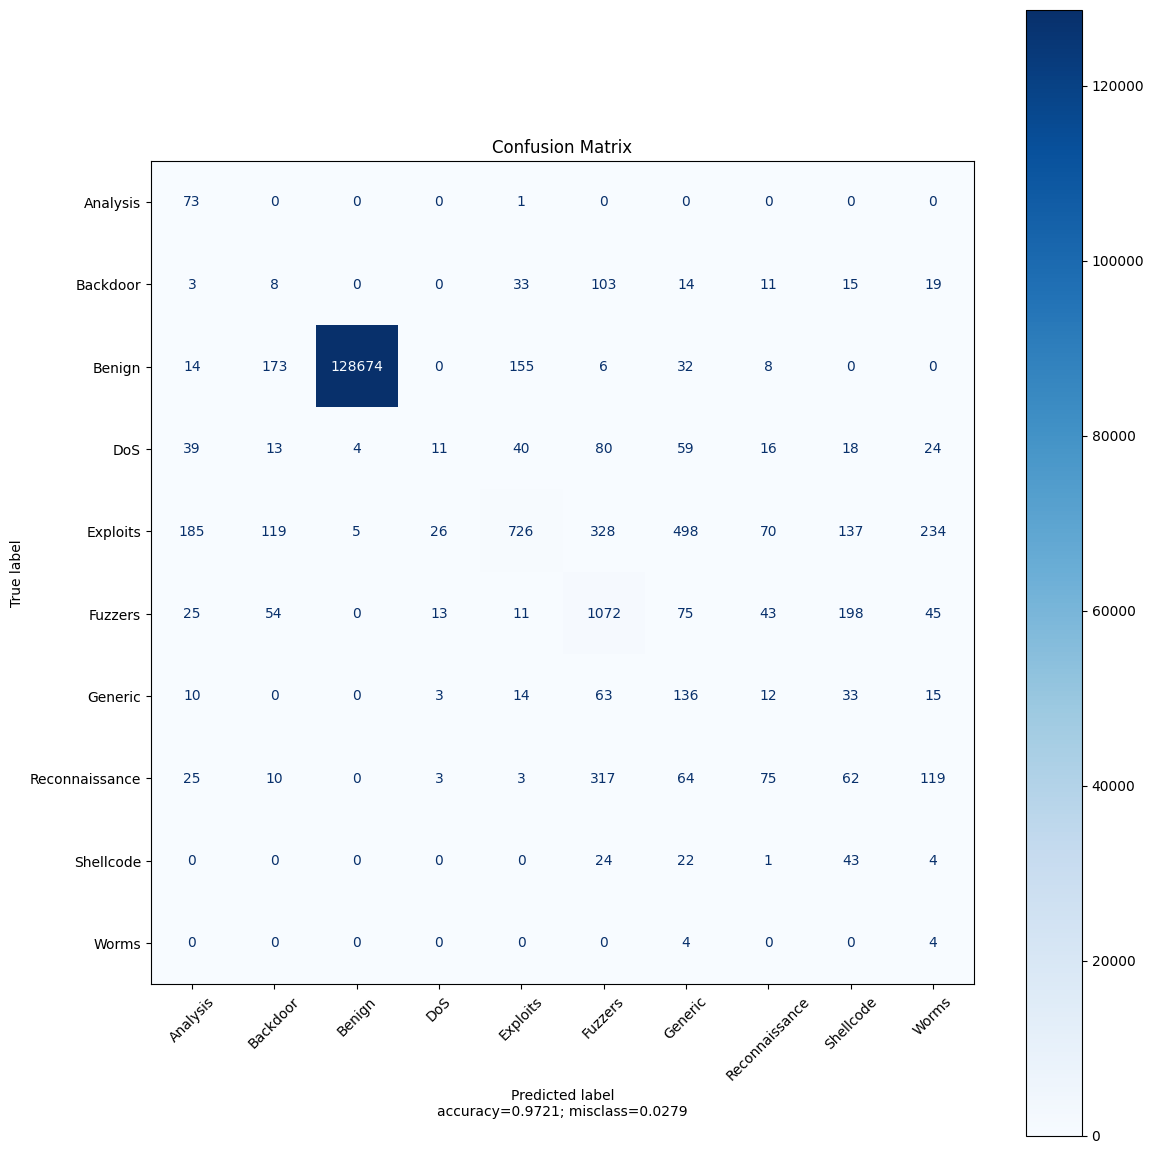

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(actual, test_pred)
labels = np.unique(actual)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap=plt.get_cmap('Blues'), colorbar=True)
plt.title("Confusion Matrix")
plt.xlabel(f'Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}')
plt.ylabel('True label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
""" import networkx as nx
import matplotlib.pyplot as plt

# If G is a NetworkX graph
nx_G = G.to_networkx()
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(nx_G, seed=42)  # or use another layout
nx.draw(nx_G, pos, node_size=20, edge_color='gray', with_labels=False)
plt.title("NetworkX Graph Visualization")
plt.show() """

KeyboardInterrupt: 

<Figure size 1200x1200 with 0 Axes>